# Objetivo

## Reduzir churn

A empresa de telecomunicações contratou a A3Data para avaliar o cenário de
churn elevado dos seus clientes e, uma vez que estamos falando de um produto
com custo elevado de setup (instalação), a empresa gostaria de uma estratégia
para reduzir esse churn.

# Imports iniciais

In [1]:
import pandas as pd
import numpy as np
from typing import Dict, Any, List

from xgboost import XGBClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV

from sklearn.metrics import (
    RocCurveDisplay,
    classification_report,
    roc_auc_score,
    confusion_matrix,
)



In [2]:
RANDOM_STATE = 42
TEST_SIZE = 0.25
N_SPLITS = 5
TOP_K_IMPORTANCES = 15
RF_N_EST = 1000
XGB_N_EST = 1000  

In [3]:
churn = pd.read_csv('data/customer_churn_verified.csv')

In [4]:
churn.head(5)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,tenure_bucket,charge_quantile,addon_count,ChurnFlag,high_value_customer
0,7569-NMZYQ,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,Yes,...,Yes,Bank transfer (automatic),118.75,8672.45,No,61m+,Q4,6,0,1
1,8984-HPEMB,Female,0,No,No,71,Yes,Yes,Fiber optic,Yes,...,Yes,Electronic check,118.65,8477.60,No,61m+,Q4,6,0,1
2,5989-AXPUC,Female,0,Yes,No,68,Yes,Yes,Fiber optic,Yes,...,No,Mailed check,118.60,7990.05,No,61m+,Q4,6,0,1
3,5734-EJKXG,Female,0,No,No,61,Yes,Yes,Fiber optic,Yes,...,Yes,Electronic check,118.60,7365.70,No,61m+,Q4,6,0,1
4,8199-ZLLSA,Male,0,No,No,67,Yes,Yes,Fiber optic,Yes,...,Yes,Bank transfer (automatic),118.35,7804.15,Yes,61m+,Q4,6,1,1


# Preparação

In [5]:
num_cols = ["MonthlyCharges", "addon_count"]
cat_cols = [
    c
    for c in churn.columns
    if c not in num_cols + ["customerID", "Churn", "ChurnFlag", 'tenure_bucket', 'charge_quantile',]
    and churn[c].dtype == "object"
]

In [6]:
churn["ChurnFlag"] = churn["Churn"].map({"No": 0, "Yes": 1})

In [7]:
cat_cols += ['SeniorCitizen']

In [8]:
X = churn[num_cols + cat_cols]
y = churn["ChurnFlag"]

In [9]:
cat_cols

['gender',
 'Partner',
 'Dependents',
 'PhoneService',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod',
 'SeniorCitizen']

In [10]:
random_number = 42

In [11]:
def build_preprocessor(
    num_cols: List[str],
    cat_cols: List[str]) -> ColumnTransformer:

    """ColumnTransformer: imputação + escala (num)  e imputa + OHE (cat)."""

    numeric_pipe = Pipeline(
        [
            ("impute", SimpleImputer(strategy="median")),
            ("scale", StandardScaler()),
        ])

    categorical_pipe = Pipeline(
        [
            ("impute", SimpleImputer(strategy="most_frequent")),
            ("encode", OneHotEncoder(handle_unknown="ignore")),
        ])
    
    preprocess = ColumnTransformer(
    [
        ("num", numeric_pipe, num_cols),
        ("cat", categorical_pipe, cat_cols),
    ])
    
    return preprocess

In [12]:
def build_selector() -> RFECV:
    """
    RFECV usando Regressão Logística L2 como estimador base.
    Seleção guiada por AUC, avaliada em k-fold estratificado.
    """
    base_estimator = LogisticRegression(
        solver="liblinear",
        penalty="l2",
        class_weight="balanced",
        max_iter=3000,
        random_state=RANDOM_STATE,
    )
    return RFECV(
        estimator=base_estimator,
        step=1,
        cv=StratifiedKFold(
            n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_STATE
        ),
        scoring="roc_auc",
        min_features_to_select=10,
        n_jobs=-1,
    )

# Modelagem

In [13]:
def train_model(
    name: str,
    estimator,
    preprocessor: ColumnTransformer,
    selector: RFECV,
    X_train: pd.DataFrame,
    X_test: pd.DataFrame,
    y_train: pd.Series,
    y_test: pd.Series,
) -> Dict[str, Any]:
    
    """
    Treina <estimator> dentro de um Pipeline, avalia no hold-out
    e retorna métricas + importância de variáveis (quando disponível).

    Parameters
    ----------
    name : str
        Rótulo para o modelo (ex.: 'RandomForest').
    estimator : scikit-learn estimator
        Algoritmo de classificação já instanciado.
    preprocess : ColumnTransformer
        Transformações numéricas/categóricas.
    X_train, X_test, y_train, y_test
        Conjuntos de dados estratificados.
    num_cols, cat_cols : list[str]
        Listas originais de colunas numéricas e categóricas.

    Returns
    -------
    dict
        Contém métricas, previsões, nomes de features expandidas
        e DataFrame `importance_df` ordenado (ou None).
    """
    
    pipe = Pipeline(
        [("prep", preprocessor), ("select", selector), ("clf", estimator)]
    )

    pipe.fit(X_train, y_train)
    proba = pipe.predict_proba(X_test)[:, 1]
    pred = pipe.predict(X_test)

    print(f"\n===== {name} =====")
    print(classification_report(y_test, pred, digits=3))
    print(f"AUC: {roc_auc_score(y_test, proba):.3f}")

    auc = roc_auc_score(y_test, proba)
    cm = confusion_matrix(y_test, pred)
    report = classification_report(y_test, pred, digits=3, output_dict=True)

    RocCurveDisplay.from_predictions(y_test, proba).plot()

    encoder = (
            pipe.named_steps["prep"]
            .named_transformers_["cat"]
            .named_steps["encode"]
        )

    cat_feats = encoder.get_feature_names_out(cat_cols).tolist()
    numeric_feats = num_cols
    feat_names = numeric_feats + cat_feats
    
    mask = pipe.named_steps["select"].support_
    selected_feats = np.array(feat_names)[mask]

    if hasattr(estimator, "feature_importances_"):

        importances = estimator.feature_importances_
        importance_df = (
            pd.DataFrame(
                {"feature": selected_feats, "importance": importances}
            )
            .sort_values("importance", ascending=False)
        )

    elif hasattr(estimator, "coef_"):
        importances = np.abs(estimator.coef_).ravel()

        importance_df = (
            pd.DataFrame({"feature": selected_feats, "importance": importances})
            .sort_values("importance", ascending=False)
            .reset_index(drop=True)
        )


    return {
        "name": name,
        "model": pipe,
        "auc": auc,
        "cm": cm,
        "report": report,
        "feature_names": selected_feats,
        "importances": importances,
        "importance_df": importance_df,
        "pred": pred,
        "proba": proba,
    }

In [14]:
preprocessor = build_preprocessor(num_cols, cat_cols)
selector = build_selector()

In [15]:
X_train, X_test, y_train, y_test = train_test_split(
        X,
        y,
        test_size=TEST_SIZE,
        random_state=RANDOM_STATE,
    )

In [16]:
rl_estimator = LogisticRegression(max_iter=3000, class_weight="balanced", solver="liblinear")


===== LogisticRegression =====
              precision    recall  f1-score   support

           0      0.903     0.707     0.793      1293
           1      0.494     0.791     0.608       468

    accuracy                          0.729      1761
   macro avg      0.699     0.749     0.701      1761
weighted avg      0.794     0.729     0.744      1761

AUC: 0.822


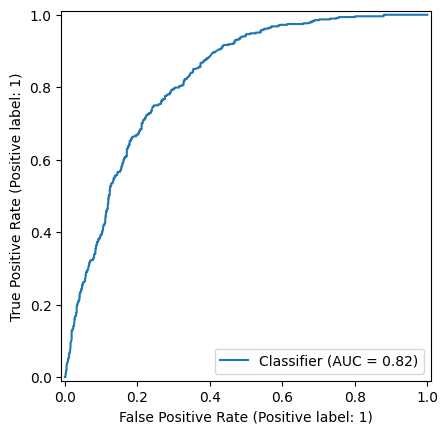

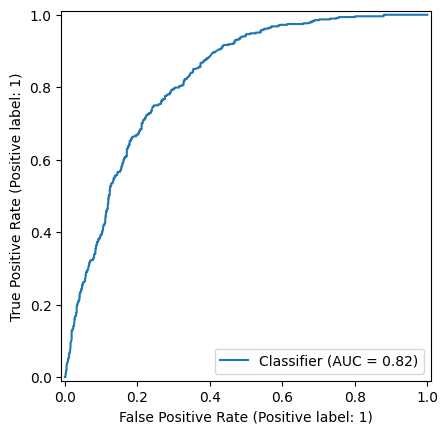

In [17]:
rl_trained = train_model(
        "LogisticRegression",
        rl_estimator,
        preprocessor,
        selector,
        X_train,
        X_test,
        y_train,
        y_test,
    )

In [18]:
rl_trained['importance_df']

,feature,importance
0,Contract_Two year,1.161649
1,Contract_Month-to-month,1.157305
2,InternetService_DSL,0.393318
3,InternetService_Fiber optic,0.384094
4,PaymentMethod_Credit card (automatic),0.243266
5,PaymentMethod_Electronic check,0.236903
6,PaperlessBilling_No,0.235639
7,OnlineSecurity_Yes,0.208278
8,PaymentMethod_Bank transfer (automatic),0.204654
9,OnlineSecurity_No,0.199054


In [19]:
rf_estimator = RandomForestClassifier(
        n_estimators=RF_N_EST,
        class_weight="balanced",
        random_state=RANDOM_STATE,
        n_jobs=-1,
    )


===== RandomForest =====
              precision    recall  f1-score   support

           0      0.822     0.842     0.832      1293
           1      0.532     0.496     0.513       468

    accuracy                          0.750      1761
   macro avg      0.677     0.669     0.673      1761
weighted avg      0.745     0.750     0.747      1761

AUC: 0.781


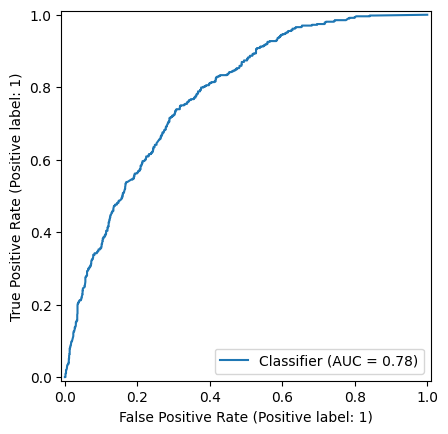

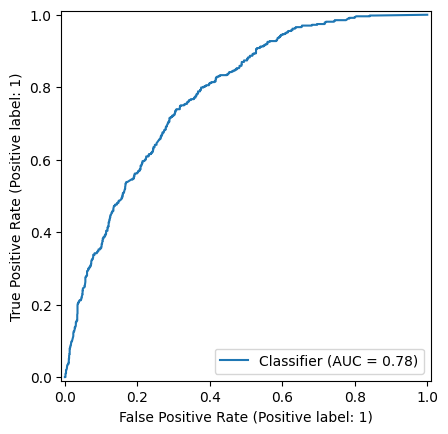

In [20]:
rf_trained = train_model(
        "RandomForest",
        rf_estimator,
        preprocessor,
        selector,
        X_train,
        X_test,
        y_train,
        y_test,
    )

In [21]:
rf_trained['importance_df'].shape

(43, 2)

In [22]:
rf_trained['importance_df']

,feature,importance
33,Contract_Month-to-month,0.100282
0,addon_count,0.053110
35,Contract_Two year,0.051292
24,TechSupport_No,0.045367
40,PaymentMethod_Electronic check,0.041726
15,OnlineSecurity_No,0.041280
42,SeniorCitizen_0,0.038623
13,InternetService_Fiber optic,0.033621
1,gender_Female,0.029665
2,gender_Male,0.029210


In [23]:
xgb_estimator = XGBClassifier(
        n_estimators=XGB_N_EST,
        max_depth=5,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        scale_pos_weight=(y == 0).sum() / (y == 1).sum(),
        eval_metric="logloss",
        random_state=RANDOM_STATE,
        n_jobs=-1,
    )


===== XGBoost =====
              precision    recall  f1-score   support

           0      0.857     0.762     0.806      1293
           1      0.496     0.647     0.562       468

    accuracy                          0.731      1761
   macro avg      0.676     0.705     0.684      1761
weighted avg      0.761     0.731     0.741      1761

AUC: 0.776


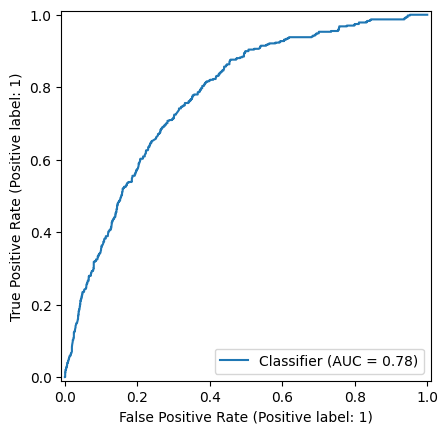

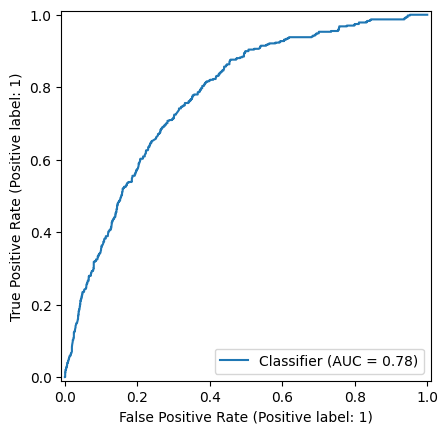

In [24]:
xgb_trained = train_model(
        "XGBoost",
        xgb_estimator,
        preprocessor,
        selector,
        X_train,
        X_test,
        y_train,
        y_test,
    )

In [25]:
xgb_trained['importance_df'].shape

(43, 2)

In [26]:
summary_rows = []
models_info = [rl_trained, rf_trained, xgb_trained]
for m in models_info:
    prec = m["report"]["weighted avg"]["precision"]
    rec = m["report"]["weighted avg"]["recall"]
    f1 = m["report"]["weighted avg"]["f1-score"]
    summary_rows.append(
        {
            "Model": m["name"],
            "AUC": round(m["auc"], 3),
            "Precision": round(prec, 3),
            "Recall": round(rec, 3),
            "F1": round(f1, 3),
        }
    )
summary_churn = pd.DataFrame(summary_rows)

In [27]:
summary_churn

,Model,AUC,Precision,Recall,F1
0,LogisticRegression,0.822,0.794,0.729,0.744
1,RandomForest,0.781,0.745,0.750,0.747
2,XGBoost,0.776,0.761,0.731,0.741


Seguimos com a RandomForest pois é o modelo mais equilibrado.

# Verificando o modelo

In [28]:
X_train

,MonthlyCharges,addon_count,gender,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,SeniorCitizen
6607,19.75,0,Male,No,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Bank transfer (automatic),0
2598,80.45,1,Male,No,Yes,Yes,Yes,Fiber optic,Yes,No,No,No,No,No,Month-to-month,Yes,Mailed check,1
2345,84.00,1,Female,No,No,Yes,Yes,Fiber optic,No,No,No,No,Yes,No,Month-to-month,Yes,Electronic check,0
4093,60.50,3,Male,Yes,Yes,Yes,No,DSL,Yes,Yes,No,Yes,No,No,Two year,No,Credit card (automatic),0
693,103.00,4,Male,Yes,No,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3772,68.35,4,Male,No,No,Yes,No,DSL,Yes,No,Yes,Yes,Yes,No,Month-to-month,Yes,Electronic check,0
5191,40.25,3,Female,No,Yes,No,No phone service,DSL,Yes,Yes,No,Yes,No,No,One year,No,Mailed check,0
5226,39.20,2,Male,Yes,Yes,No,No phone service,DSL,Yes,No,No,No,No,Yes,Month-to-month,Yes,Electronic check,0
5390,29.95,1,Male,Yes,Yes,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,0


In [29]:
def defined_model(
    name: str,
    estimator,
    preprocessor: ColumnTransformer,
    selector: RFECV,
    X_train: pd.DataFrame,
    X_test: pd.DataFrame,
    y_train: pd.Series,
    y_test: pd.Series,
    X: pd.DataFrame,
    y: pd.Series,
) -> Dict[str, Any]:
    
    """
    Treina <estimator> dentro de um Pipeline, avalia no hold-out
    e retorna métricas + importância de variáveis (quando disponível).

    Parameters
    ----------
    name : str
        Rótulo para o modelo (ex.: 'RandomForest').
    estimator : scikit-learn estimator
        Algoritmo de classificação já instanciado.
    preprocess : ColumnTransformer
        Transformações numéricas/categóricas.
    X_train, X_test, y_train, y_test, X, y
        Conjuntos de dados estratificados.
    num_cols, cat_cols : list[str]
        Listas originais de colunas numéricas e categóricas.

    Returns
    -------
    dict
        Contém métricas, previsões, nomes de features expandidas
        e DataFrame `importance_df` ordenado (ou None).
    """
    
    pipe = Pipeline(
        [("prep", preprocessor), ("select", selector), ("clf", estimator)]
    )

    pipe.fit(X_train, y_train)
    proba = pipe.predict_proba(X)[:, 1]
    pred = pipe.predict(X)



    return {
            "name": name,
            "model": pipe,
            "pred": pred,
            "proba": proba,
        }

In [30]:
rf_defined = defined_model(
        "RandomForest",
        rf_estimator,
        preprocessor,
        selector,
        X_train,
        X_test,
        y_train,
        y_test,
        X,
        y
    )

In [31]:
churn.shape

(7043, 26)

In [32]:
rf_defined['proba'].shape

(7043,)

In [33]:
proba_rf = pd.Series(rf_defined["proba"],
                     index=X.index,
                     name="proba_rf")

churn["proba_rf"] = proba_rf

In [34]:
churn.groupby('ChurnFlag').agg({'proba_rf': 'mean'}).round(3)

,proba_rf
ChurnFlag,
0,0.154
1,0.701


In [35]:
proba_bins = [0, 0.3, 0.5, 0.70, 1]
proba_labels = ["Baixa prob.", "Média baixa prob", "Média alta prob." ,"Alta prob.",]
churn["proba_bucket"] = pd.cut(churn["proba_rf"], bins=proba_bins, 
                                labels=proba_labels)

In [36]:
churn.groupby(['proba_bucket', 'ChurnFlag']).size()

C:\Users\user\AppData\Local\Temp\ipykernel_2736\1843096876.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  churn.groupby(['proba_bucket', 'ChurnFlag']).size()


proba_bucket      ChurnFlag
Baixa prob.       0            3407
                  1             152
Média baixa prob  0             394
                  1             167
Média alta prob.  0             318
                  1             398
Alta prob.        0             228
                  1            1151
dtype: int64

In [37]:
churn.groupby('proba_bucket').agg({'ChurnFlag': 'mean'}).round(3)

C:\Users\user\AppData\Local\Temp\ipykernel_2736\4080623575.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  churn.groupby('proba_bucket').agg({'ChurnFlag': 'mean'}).round(3)


,ChurnFlag
proba_bucket,
Baixa prob.,0.043
Média baixa prob,0.298
Média alta prob.,0.556
Alta prob.,0.835


In [38]:
avg_monthly = churn["MonthlyCharges"].mean()
scenarios = {"3x": 3 * avg_monthly, "6x": 6 * avg_monthly, "12x": 12 * avg_monthly}

In [39]:
for scenario, value in scenarios.items():
    churn[f'perda_{scenario}'] = churn["TotalCharges"] - value

In [40]:
churn[churn['perda_3x'] < 0]['perda_3x'].sum()

np.float64(-131601.8054593213)

In [41]:
churn[churn['perda_6x'] < 0]['perda_6x'].sum()

np.float64(-418640.589443419)

In [42]:
churn[churn['perda_12x'] < 0]['perda_12x'].sum()

np.float64(-1259713.6718656821)

In [46]:
-90478.77/-131601.80

0.6875192436577616

In [43]:
churn[(churn['perda_3x'] < 0) & (churn['proba_bucket'] != 'Alta prob.')]['perda_3x'].sum()

np.float64(-90478.77528042028)

In [44]:
churn[(churn['perda_6x'] < 0) & (churn['proba_bucket'] != 'Alta prob.')]['perda_6x'].sum()

np.float64(-284444.6841686781)

In [45]:
churn[(churn['perda_12x'] < 0) & (churn['proba_bucket'] != 'Alta prob.')]['perda_12x'].sum()

np.float64(-873933.2862203605)